/data/users2/jwardell1/undersampling-project/OULU/pkl-files/COBRE
['/data/users2/jwardell1/undersampling-project/OULU/pkl-files/COBRE/SVM/10-15/sr1_1.5_COBRE_OULU_SVM_rbf_2024-10-15.pkl', '/data/users2/jwardell1/undersampling-project/OULU/pkl-files/COBRE/SVM/10-15/sr2_1.5_COBRE_OULU_SVM_rbf_2024-10-15.pkl', '/data/users2/jwardell1/undersampling-project/OULU/pkl-files/COBRE/SVM/10-15/concat_1.5_COBRE_OULU_SVM_rbf_2024-10-15.pkl', '/data/users2/jwardell1/undersampling-project/OULU/pkl-files/COBRE/SVM/10-15/add_1.5_COBRE_OULU_SVM_rbf_2024-10-15.pkl', '/data/users2/jwardell1/undersampling-project/OULU/pkl-files/COBRE/SVM/10-15/sr2_1.6_COBRE_OULU_SVM_rbf_2024-10-15.pkl', '/data/users2/jwardell1/undersampling-project/OULU/pkl-files/COBRE/SVM/10-15/sr1_1.8_COBRE_OULU_SVM_rbf_2024-10-15.pkl', '/data/users2/jwardell1/undersampling-project/OULU/pkl-files/COBRE/SVM/10-15/add_1.6_COBRE_OULU_SVM_rbf_2024-10-15.pkl', '/data/users2/jwardell1/undersampling-project/OULU/pkl-files/COBRE/SVM/10-15/sr1_1.

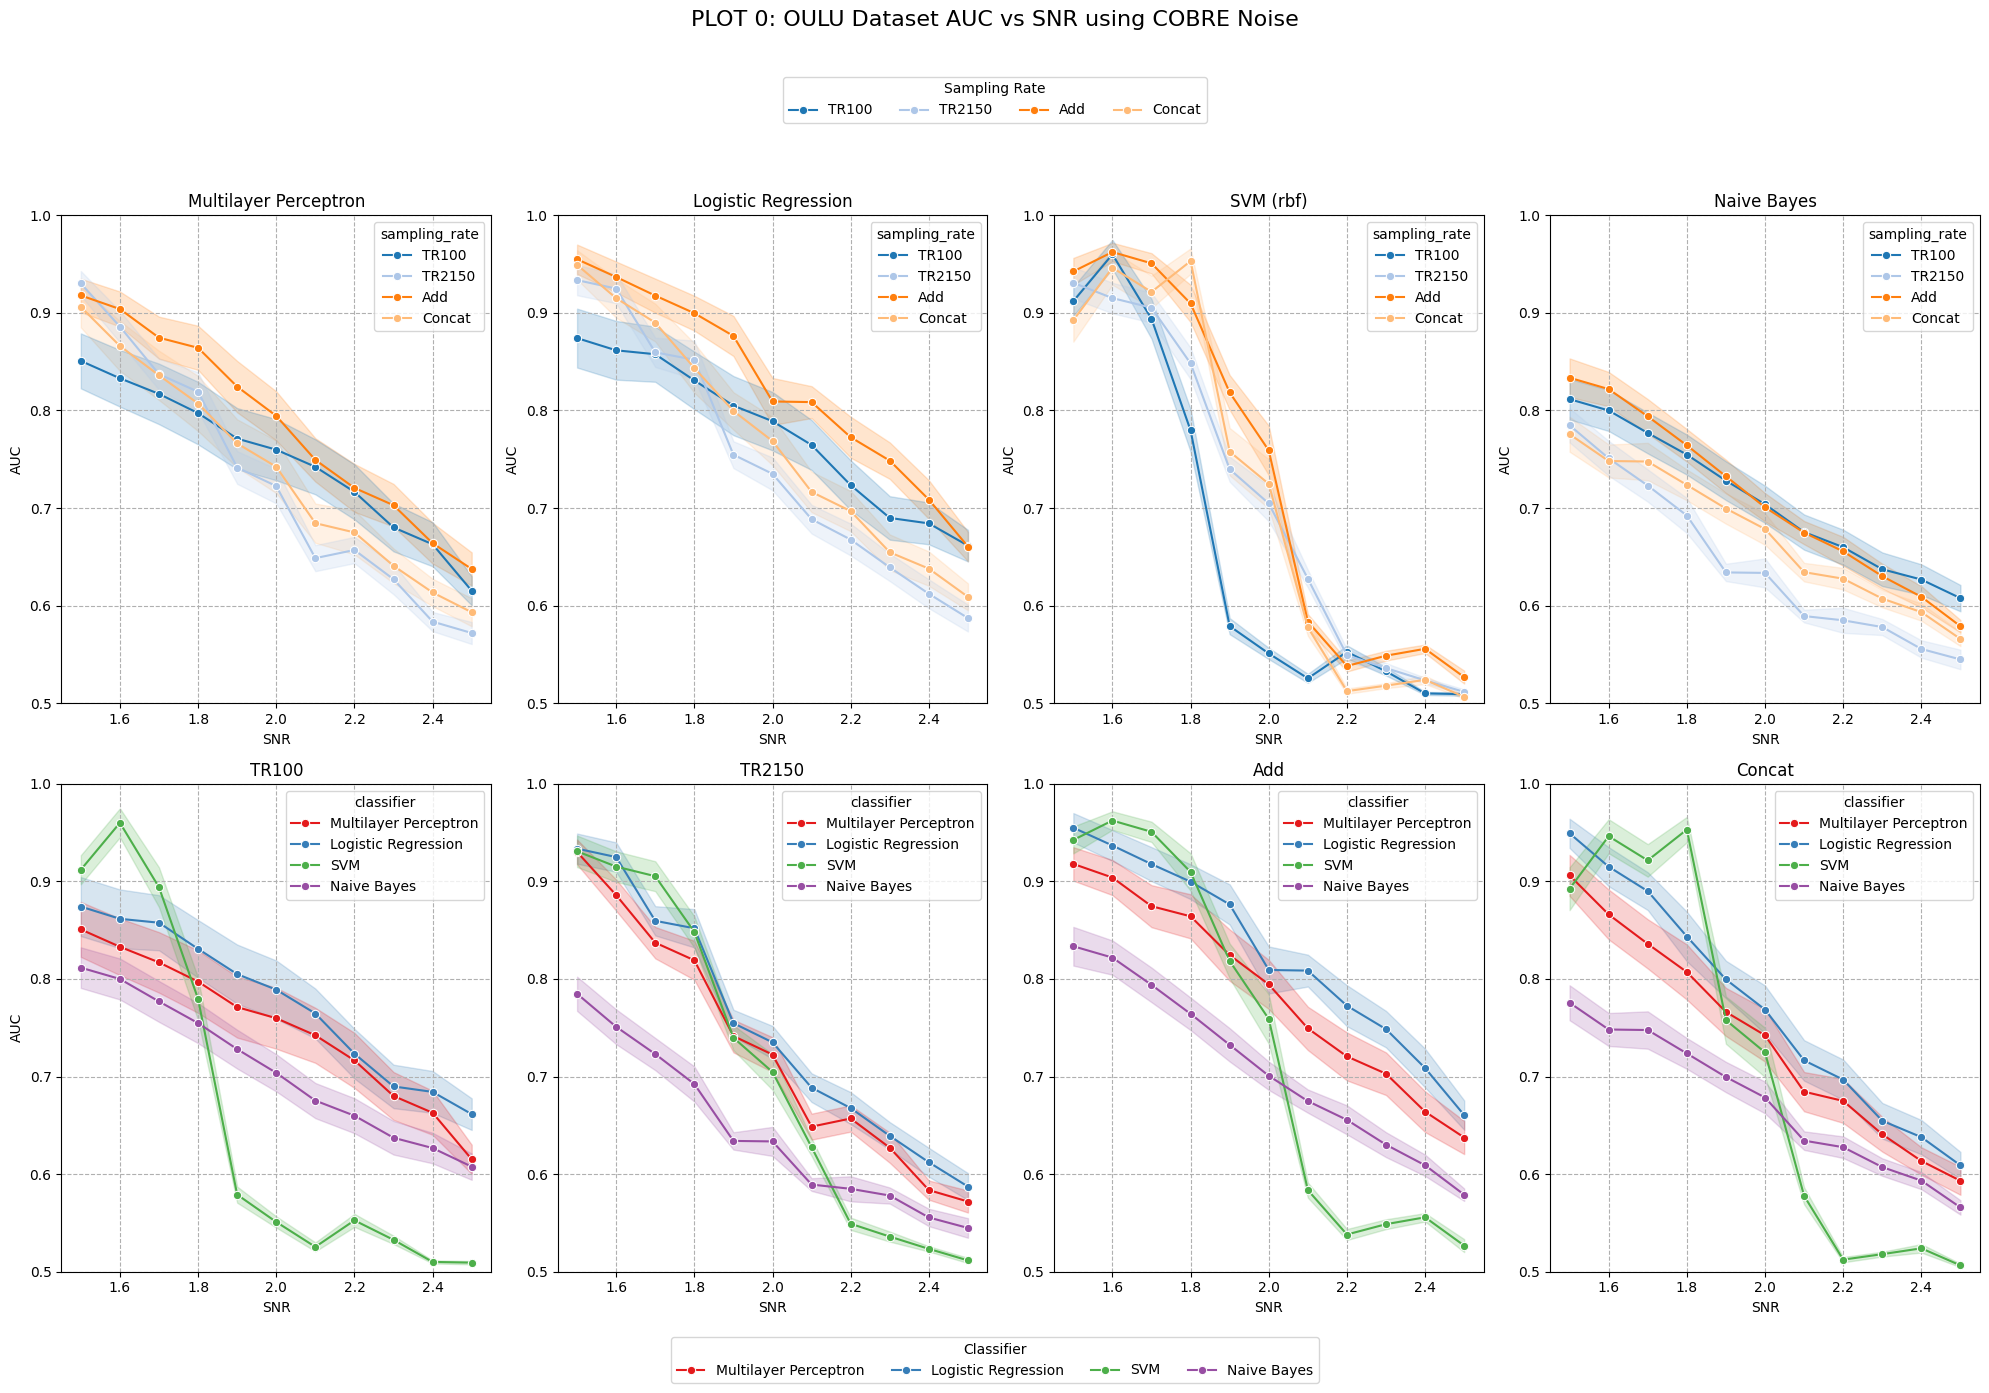

In [13]:
import os
import glob
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations
import numpy as np


signal_dataset = 'oulu'
noise_dataset = 'fbirn'

plot_all = False

kernel_type = 'rbf'
sklearn = False




def plot(noise_dataset, signal_dataset, sklearn, kernel_type, plot_no):

    # Define the directory for the current undersampling rate
    pkl_dir = f'/data/users2/jwardell1/undersampling-project/{signal_dataset.upper()}/pkl-files/{noise_dataset.upper()}'
    print(pkl_dir)

    if sklearn:
        joined_files = os.path.join(f'{pkl_dir}/SVM/sklearn', f'*{kernel_type}*.pkl')
    else:
        joined_files = os.path.join(f'{pkl_dir}/SVM/10-18', f'*{kernel_type}*.pkl')
    joined_list = glob.glob(joined_files)
    print(joined_list)
    thundersvm_df = pd.concat((pd.read_pickle(file).assign(classifier='SVM') for file in joined_list), ignore_index=True)






    # Read and concatenate sr1 data
    joined_files = os.path.join(pkl_dir, 'sr1_*.pkl')
    joined_list = glob.glob(joined_files)
    sr1 = pd.concat((pd.read_pickle(file).assign(sampling_rate='sr1') for file in joined_list), ignore_index=True)

    # Read and concatenate sr2 data
    joined_files = os.path.join(pkl_dir, 'sr2_*.pkl')
    joined_list = glob.glob(joined_files)
    sr2 = pd.concat((pd.read_pickle(file).assign(sampling_rate='sr2') for file in joined_list), ignore_index=True)

    # Read and concatenate concat data
    joined_files = os.path.join(pkl_dir, 'concat_*.pkl')
    joined_list = glob.glob(joined_files)
    concat = pd.concat((pd.read_pickle(file).assign(sampling_rate='concat') for file in joined_list), ignore_index=True)

    # Read and concatenate add data
    joined_files = os.path.join(pkl_dir, 'add_*.pkl')
    joined_list = glob.glob(joined_files)
    add = pd.concat((pd.read_pickle(file).assign(sampling_rate='add') for file in joined_list), ignore_index=True)


    # Concatenate all dataframes
    all_data = pd.concat([sr1, sr2, concat, add], ignore_index=True)

    # Function to split each row into multiple rows based on cross-validation index
    def split_row(row):
        new_rows = []
        for cv_ix, auc in enumerate(row['test_scores']):
            new_row = row.copy()
            new_row['auc'] = auc
            new_row['cv_ix'] = cv_ix
            new_rows.append(new_row)
        return pd.DataFrame(new_rows)


    all_data = all_data.dropna(subset=['test_scores'])

    # Apply the split_row function to each row of the dataframe and concatenate the results
    result_df = pd.concat(all_data.apply(split_row, axis=1).tolist(), ignore_index=True)

    # Drop the original 'test_scores' column as it's no longer needed
    result_df.drop('test_scores', axis=1, inplace=True)





    # Load thundersvm_df_linear and rename 'roc' column to 'auc'
    thundersvm_df.rename(columns={'roc': 'auc'}, inplace=True)
    thundersvm_df.rename(columns={'fold': 'cv_ix'}, inplace=True)
    thundersvm_df.rename(columns={'noise_ix': 'noise_no'}, inplace=True)
    #thundersvm_df_rbf.rename(columns={'fbirn_sub': 'graph_no'}, inplace=True)




    # Filter and clean up thundersvm_df_linear
    thundersvm_df_linear = thundersvm_df[['snr', 'cv_ix', 'auc', 'sampling_rate', 'classifier']]#'noise_no']#'graph_no', 'classifier']]
    thundersvm_df_linear = thundersvm_df.replace([np.inf, -np.inf], np.nan).dropna()




    result_df = result_df[['snr', 'cv_ix', 'auc', 'sampling_rate', 'noise_no', 'classifier']]# 'graph_no', 'classifier']]




    # Merge with thundersvm_df_linear
    result_df = pd.concat([result_df, thundersvm_df_linear], ignore_index=True)



    result_df['sampling_rate'] = result_df['sampling_rate'].replace('add', 'Add')
    result_df['sampling_rate'] = result_df['sampling_rate'].replace('concat', 'Concat')
    if signal_dataset == 'simulation':
        result_df['sampling_rate'] = result_df['sampling_rate'].replace('sr1', 'TR2200')
        result_df['sampling_rate'] = result_df['sampling_rate'].replace('sr2', 'TR2600')

    if signal_dataset == 'oulu':
        result_df['sampling_rate'] = result_df['sampling_rate'].replace('sr1', 'TR100')
        result_df['sampling_rate'] = result_df['sampling_rate'].replace('sr2', 'TR2150')

    if signal_dataset == 'hcp':
        result_df['sampling_rate'] = result_df['sampling_rate'].replace('sr1', 'SR1')
        result_df['sampling_rate'] = result_df['sampling_rate'].replace('sr2', 'SR2')

    
    


    result_df = result_df[result_df['snr'] <= 3]


    ###########################################################################################################################

    grouped_classifiers = result_df.groupby('classifier')

    classifier_dfs = {}
    for classifier, group_df in grouped_classifiers:
        classifier_dfs[classifier] = group_df.copy()

    mlp_df = classifier_dfs.get('Multilayer Perceptron', pd.DataFrame())
    lr_df = classifier_dfs.get('Logistic Regression', pd.DataFrame())
    svm_df = classifier_dfs.get('SVM', pd.DataFrame())
    nb_df = classifier_dfs.get('Naive Bayes', pd.DataFrame())

    if signal_dataset == 'simulation':
        tr1 = 'TR2200'
        tr2 = 'TR2600'

    if signal_dataset == 'oulu':        
        tr1 = 'TR100'
        tr2 = 'TR2150'

    if signal_dataset == 'hcp':
        tr1 = 'SR1'
        tr2 = 'SR2'

    dfs = [mlp_df, lr_df, svm_df, nb_df]
    classifiers = ['Multilayer Perceptron', 'Logistic Regression', 'SVM', 'Naive Bayes']
    
    sampling_rates = [tr1, tr2, 'Add', 'Concat']
    hue_order = sampling_rates
    palette = {item: plt.cm.tab20(i) for i, item in enumerate(sampling_rates)}

    # Combine all dataframes into one dataframe for plotting
    combined_df = pd.concat(dfs)
    snr_levels = [1.6, 1.7, 1.8, 1.9, 2.0, 2.1, 2.2, 2.3, 2.4, 2.5]



    # Define your variables
    x = "snr"
    y = "auc"
    hue = "sampling_rate"
    order = snr_levels

    # Create the figure and the axes
    fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(20, 12), gridspec_kw={'height_ratios': [1, 1]})

    # Collect y-limits for determining the common range
    all_y_vals = []

    # Plot the first row with sampling_rate as hue
    for i, classifier in enumerate(classifiers):
        # Filter the data for the current classifier
        data_filtered = combined_df[combined_df['classifier'] == classifier]

        # Lineplot with error bands
        summary_df = data_filtered.groupby([x, hue]).agg(
            mean_auc=(y, 'mean'),
            std_auc=(y, 'std'),
            count=(y, 'count')
        ).reset_index()
        summary_df['se_auc'] = summary_df['std_auc'] / np.sqrt(summary_df['count'])
        
        sns.lineplot(
            data=summary_df, x=x, y='mean_auc', hue=hue, hue_order=hue_order,
            palette=palette, marker='o', ax=axes[0, i]
        )
        
        # Add error bands manually
        for key, grp in summary_df.groupby(hue):
            color = palette[key]
            axes[0, i].fill_between(grp[x], grp['mean_auc'] - grp['se_auc'], grp['mean_auc'] + grp['se_auc'], color=color, alpha=0.2)
        
        if classifier == 'SVM':
            axes[0, i].set_title(f'{classifier} ({kernel_type})')
        else:
            axes[0, i].set_title(f'{classifier}')
        axes[0, i].set_ylim(0.5, 1)  # Setting y-limit
        axes[0, i].set_xlabel('SNR')
        axes[0, i].set_ylabel('AUC')


    # Adjust hue_order and palette for the second row
    hue_order = classifiers
    classifier_palette = sns.color_palette("Set1", len(classifiers))
    palette = {item: classifier_palette[i] for i, item in enumerate(classifiers)}

    # Plot the second row with classifier as hue
    for i, sampling_rate in enumerate(sampling_rates):
        # Filter the data for the current sampling rate
        data_filtered = combined_df[combined_df['sampling_rate'] == sampling_rate]

        # Lineplot with error bands
        summary_df = data_filtered.groupby([x, 'classifier']).agg(
            mean_auc=(y, 'mean'),
            std_auc=(y, 'std'),
            count=(y, 'count')
        ).reset_index()
        summary_df['se_auc'] = summary_df['std_auc'] / np.sqrt(summary_df['count'])
        
        sns.lineplot(
            data=summary_df, x=x, y='mean_auc', hue='classifier', hue_order=hue_order,
            palette=palette, marker='o', ax=axes[1, i]
        )
        
        # Add error bands manually
        for key, grp in summary_df.groupby('classifier'):
            color = palette[key]
            axes[1, i].fill_between(grp[x], grp['mean_auc'] - grp['se_auc'], grp['mean_auc'] + grp['se_auc'], color=color, alpha=0.2)
        
        # Collect y-values
        all_y_vals.extend(data_filtered[y].values)
        
        axes[1, i].set_title(f'{sampling_rate}')
        axes[1, i].set_ylim(0.5, 1)  # Setting y-limit
        axes[1, i].set_xlabel('SNR')
        if i == 0:
            axes[1, i].set_ylabel('AUC')
        else:
            axes[1, i].set_ylabel('')



    # Adjust layout
    plt.tight_layout(rect=[0, 0, 1, 0.96])

    # Add a super title
    #fig.suptitle(f"Finnish Dataset AUC vs SNR using FBIRN subject {subID} Noise", fontsize=16, y=1.10)
    fig.suptitle(f"PLOT {plot_no}: {signal_dataset.upper()} Dataset AUC vs SNR using {noise_dataset.upper()} Noise", fontsize=16, y=1.10)

    # Add grid
    for ax_row in axes:
        for ax in ax_row:
            ax.grid(True, which='both', axis='both', linestyle='--')

    # Add legends
    handles, labels = axes[0, 0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper center', ncol=len(sampling_rates), title='Sampling Rate', bbox_to_anchor=(0.5, 1.05))

    handles, labels = axes[1, 0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='lower center', ncol=len(classifiers), title='Classifier', bbox_to_anchor=(0.5, -0.05))
    plt.savefig(f'../results/{signal_dataset}_{noise_dataset}_{kernel_type}.png')

    plt.show()

if plot_all:
    plot_no = 0
    signal_datasets = ['oulu', 'hcp', 'simulation']
    noise_datasets = ['fbirn', 'cobre', 'var']
    kernels = ['rbf']#, 'linear']

    for signal_dataset in signal_datasets:
        for noise_dataset in noise_datasets:
            for kernel_type in kernels:
                try:
                    plot(noise_dataset, signal_dataset, sklearn, kernel_type, plot_no)
                    plot_no += 1
                except ValueError as e:
                    pass
                    #print(f'error poltting {signal_dataset} {noise_dataset} {kernel_type} sklearn {sklearn}')

else:
    plot(noise_dataset, signal_dataset, sklearn, kernel_type, 0)


/tmp/ipykernel_3370585/3703077988.py:12: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.lineplot(


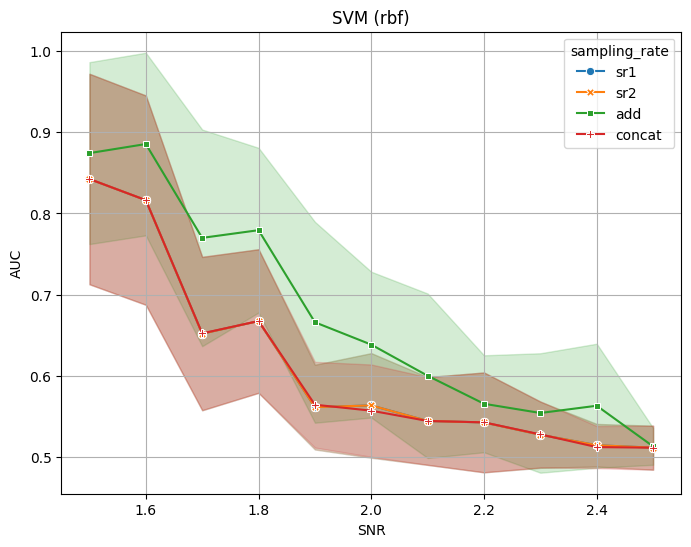

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Assuming you have your combined_df loaded
combined_df = pd.read_csv("/data/users2/jwardell1/undersampling-project/SIMULATION/pkl-files/FBIRN/SVM/csv/combined_output.csv") # if you are loading it from a file

# Create the plot
plt.figure(figsize=(8, 6))

# Use seaborn's lineplot to plot data with confidence interval
sns.lineplot(
    data=combined_df, 
    x='snr', 
    y='roc', 
    hue='sampling_rate', 
    style='sampling_rate', 
    markers=True, 
    dashes=False, 
    ci='sd'
)

# Customize the plot to match the example
plt.title("SVM (rbf)")
plt.xlabel("SNR")
plt.ylabel("AUC")
plt.grid(True)
plt.legend(title='sampling_rate')

# Show the plot
plt.show()


In [1]:
import logging
import argparse
from datetime import datetime

import pandas as pd
import numpy as np

import scipy.io

from utils.polyssifier import poly
from utils.usp_utils import *


project_dir = '/data/users2/jwardell1/undersampling-project'

data_params = {}

n_threads = 1

noise_dataset = 'fbirn'.upper()
signal_dataset = 'hcp'.upper()
n_folds = 7
num_noise = 1
log_level = 'DEBUG'

lower = 1.5
upper = 2.5
step = 0.1

SNRs = np.round(np.arange(lower, upper+step, step), 1)

logging.basicConfig(level=log_level, format='%(asctime)s - %(levelname)s - %(message)s')
# Print the parsed arguments to verify
logging.info(f'Noise Interval: {SNRs}')
logging.info(f'Noise Dataset: {noise_dataset}')
logging.info(f'Signal Dataset: {signal_dataset}')
logging.info(f'Number of Folds: {n_folds}')
logging.info(f'Noise Iterations: {num_noise}')


data_params['noise_dataset'] = noise_dataset
data_params['signal_dataset'] = signal_dataset

signal_data = pd.read_pickle(f'{project_dir}/assets/data/{signal_dataset}_data.pkl')
noise_data = scipy.io.loadmat(f'{project_dir}/assets/data/{noise_dataset}_data.mat')

subjects = np.unique(signal_data['subject'])
data_params['subjects'] = subjects


if noise_dataset == "VAR":
    A = noise_data['A']
    u_rate = 1
    nstd = 1.0
    burn = 100
    threshold = 0.0001
    
    logging.debug(f'A - {A}')
    logging.debug(f'u_rate - {u_rate}')
    logging.debug(f'nstd - {nstd}')
    logging.debug(f'burn - {burn}')
    logging.debug(f'threshold - {threshold}')


    data_params['A'] = A
    data_params['u_rate'] = u_rate
    data_params['nstd'] = nstd
    data_params['burn'] = burn
    data_params['threshold'] = threshold

else:
    L = noise_data['L']
    covariance_matrix = noise_data['cov_mat']

    logging.debug(f'L {L}')
    logging.debug(f'covariance_matrix {covariance_matrix}')

    data_params['L'] = L
    data_params['covariance_matrix'] = covariance_matrix

if signal_dataset == 'OULU':
    undersampling_rate = 1
    NOISE_SIZE = 2961*2

if signal_dataset == 'SIMULATION':
    undersampling_rate = 1
    NOISE_SIZE = 18018 #might should write a function to compute this, it is LCM(t1*k1, t2*k2)

if signal_dataset == 'HCP':
    NOISE_SIZE = 1200
    undersampling_rate = 6



data_params['NOISE_SIZE'] = NOISE_SIZE
data_params['undersampling_rate'] = undersampling_rate




2024-10-11 14:46:02,078 - INFO - Noise Interval: [1.5 1.6 1.7 1.8 1.9 2.  2.1 2.2 2.3 2.4 2.5]
2024-10-11 14:46:02,079 - INFO - Noise Dataset: FBIRN
2024-10-11 14:46:02,080 - INFO - Signal Dataset: HCP
2024-10-11 14:46:02,082 - INFO - Number of Folds: 7
2024-10-11 14:46:02,083 - INFO - Noise Iterations: 1
2024-10-11 14:46:02,099 - DEBUG - L [[ 4.08587162  0.          0.         ...  0.          0.
   0.        ]
 [-1.04119378  1.53074965  0.         ...  0.          0.
   0.        ]
 [-0.50307219 -0.63562454  2.59796817 ...  0.          0.
   0.        ]
 ...
 [-0.04176643 -0.82134988  0.04404994 ...  0.77944902  0.
   0.        ]
 [ 0.1835621  -1.47832245  0.67131061 ... -0.08794544  0.47695121
   0.        ]
 [ 0.69862444  0.49187431 -0.42517559 ... -0.25786669 -0.20272737
   0.51013157]]
2024-10-11 14:46:02,100 - DEBUG - covariance_matrix [[16.69434687 -4.25418413 -2.05548836 ... -0.17065226  0.75001118
   2.85448979]
 [-4.25418413  3.42727899 -0.44918641 ... -1.21379409 -2.4540652

In [2]:
SNR = SNRs[0]

data_params['SNR'] = SNR

all_data = load_timecourses(signal_data, data_params)


data_df = pd.DataFrame(all_data)



################ windowing
sr1_data, sr2_data, add_data, concat_data = perform_windowing(data_df)


sr1_df = pd.DataFrame(sr1_data)
sr2_df = pd.DataFrame(sr2_data)
add_df = pd.DataFrame(add_data)



2024-10-11 14:46:04,333 - DEBUG - computed noise for subject: 377451
2024-10-11 14:46:04,335 - DEBUG - noises[subject].shape (53, 1200)
2024-10-11 14:46:04,336 - DEBUG - loading timecourse for subject 377451
2024-10-11 14:46:04,337 - DEBUG - HCP dataset detected during loading
2024-10-11 14:46:04,393 - DEBUG - subject 377451 SR1 shape - (53, 1200)
2024-10-11 14:46:04,410 - DEBUG - subject 377451 SR2 shape - (53, 200)
2024-10-11 14:46:04,503 - DEBUG - computed noise for subject: 378857
2024-10-11 14:46:04,505 - DEBUG - noises[subject].shape (53, 1200)
2024-10-11 14:46:04,506 - DEBUG - loading timecourse for subject 378857
2024-10-11 14:46:04,507 - DEBUG - HCP dataset detected during loading
2024-10-11 14:46:04,537 - DEBUG - subject 378857 SR1 shape - (53, 1200)
2024-10-11 14:46:04,539 - DEBUG - subject 378857 SR2 shape - (53, 200)
2024-10-11 14:46:04,651 - DEBUG - computed noise for subject: 379657
2024-10-11 14:46:04,652 - DEBUG - noises[subject].shape (53, 1200)
2024-10-11 14:46:04,65

In [9]:
X_sr1, y_sr1, group_sr1 = parse_X_y_groups(pd.DataFrame(sr1_data), 'SR1')
X_sr2, y_sr2, group_sr2 = parse_X_y_groups(pd.DataFrame(sr2_data), 'SR2')
X_add, y_add, group_add = parse_X_y_groups(pd.DataFrame(add_data), 'Add')
X_concat, y_concat, group_concat = parse_X_y_groups(pd.DataFrame(concat_data), 'Concat')

y_sr1

array(['0', '1', '0', ..., '1', '0', '1'], dtype='<U1')

In [10]:
y_sr1 = np.where(y_sr1 == '0', -1, 1)
y_sr2 = np.where(y_sr2 == '0', -1, 1)
y_add = np.where(y_add == '0', -1, 1)
y_concat = np.where(y_concat == '0', -1, 1)

In [11]:
"""from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler2 = StandardScaler()
X_sr1 = scaler.fit_transform(X_sr1)
X_sr2 = scaler.fit_transform(X_sr2)
X_add = scaler.fit_transform(X_add)
X_concat = scaler2.fit_transform(X_concat)

"""
np.savez("X_sr1", X_sr1)
np.savez("X_sr2", X_sr2)
np.savez("X_add", X_add)
np.savez("X_concat", X_concat)


In [22]:
X_concat

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])